In [ ]:
# develop-exponential-decay-translation.ipynb
#
# Bryan Daniels
# 2024/1/25
#
# Trying to get closer to a "Laplace transform of delta functions" by
# specifying that individual neuron states decay exponentially over time
#
# Working from results in develop-self-sustained-translation-operator.ipynb

In [1]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from toolbox import defaultFigure
defaultFigure.setDefaultParams()

from laplace_network import laplace_network,find_edge_location,interaction_matrix_from_kernel

In [2]:
delta_z = 1./4. #0.5 #1 
n_0 = 25 # *** 15 # 25 (25 used for 231117 plots)

# define the shapes of edges and bumps we want in order to get exponential decay

def desiredEdgeRates(n,t,delta_z=delta_z,n_0=n_0):
    return np.exp(-t/np.exp(delta_z*(n-n_0)))

def desiredBumpRates(n,t,delta_z=delta_z,n_0=n_0):
    return t*desiredEdgeRates(n,t,delta_z=delta_z,n_0=n_0)*delta_z/np.exp(delta_z*(n-n_0))

In [38]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

Npopulation = 50 # number of units in each population
# delta_z is the conversion unit from distance measured in number of neurons 
# to the relevant output variable z (effectively set to 1 for 231117 plots)
# constant interaction strength between neighbors
J = 2 
# constant interaction from edge neurons to corresponding bump neurons
J_edge_bump = 1
# strength of feedback from bump to edge neurons varies with n
t_0 = 10. #10. #1. (1. used for 231117 plots) #0.1 #0.5 
J_bump_edge_max = 0.1 #10 # to avoid instability
J_bump_edge_scale_factor = 1 #2 #0.1 #0.5 #0.9 (0.9 used for 231117 plots)
J_bump_edge = [ -J_bump_edge_scale_factor*min(1./t_0*1./delta_z*np.exp(-delta_z*(n-n_0)),
                                              J_bump_edge_max) for n in range(Npopulation) ]
kernel_width = 2 #1 # 0.1 # (set to default 2 for 231117 plots)
nonlinearity = lambda x: 2*np.heaviside(x,0.5) - 1 # np.tanh

net = laplace_network(Npopulation,J,
                      J_edge_bump=J_edge_bump,
                      J_bump_edge=J_bump_edge,
                      kernel_width=kernel_width,
                      nonlinearity=nonlinearity)

# 2024/1/23 try replacing edge interaction kernel to give the desired steady state given the 
# step-function nonlinearity
# TO DO: CHECK t_0 here.  I set it to 1---is this right?
net.edge_Jmat = J*interaction_matrix_from_kernel([desiredBumpRates(30-n,1,n_0=14) for n in range(31)],Npopulation)
net.Jmat = np.block([[net.edge_Jmat, net.bump_edge_Jmat],
                     [net.edge_bump_Jmat, net.bump_Jmat]])
net.Jmat_no_feedback = np.block([[net.edge_Jmat, np.zeros((Npopulation,Npopulation))],
                                 [net.edge_bump_Jmat, net.bump_Jmat]])

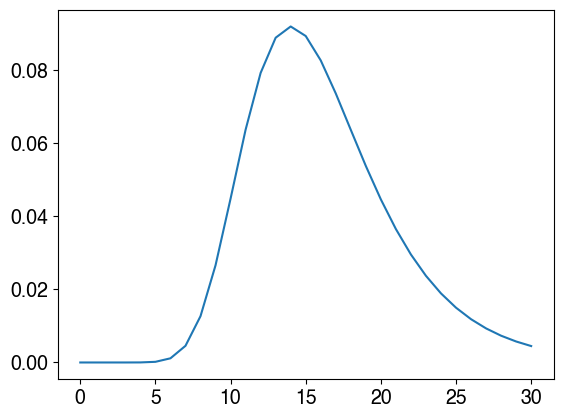

In [4]:
plt.plot([desiredBumpRates(n,1,n_0=14) for n in range(31)])

In [39]:
# run simulation

noise_var = 1e-6 #1e-4 (1e-4 used for 231117 plots) # 0.1 # strength of noise (variance added per unit time)
i_final = 7 #6 #5 #(t increases exponentially with i) #100 #20
t_final = t_0 + 2**(i_final-1)
delta_t = 0.001 #0.001
seed = 12345

# start with edge state at location n_0 at time t_0
edge_t = 1
initial_guess_edge = net.J*(2*desiredEdgeRates(np.arange(0,Npopulation),edge_t,delta_z=delta_z,n_0=n_0)-1)
#initial_guess_edge += net.inputExt[:Npopulation]
edge_state = net.find_edge_state(n_0,
                                 initial_guess_edge=initial_guess_edge,
                                 method='minimize')
    
# simulate dynamics
states = net.simulate_dynamics(edge_state,
                               t_final-t_0,
                               noise_var,
                               additional_input=None,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states.index = states.index + t_0

(-2.45, 51.45, -10.0, 10.0)

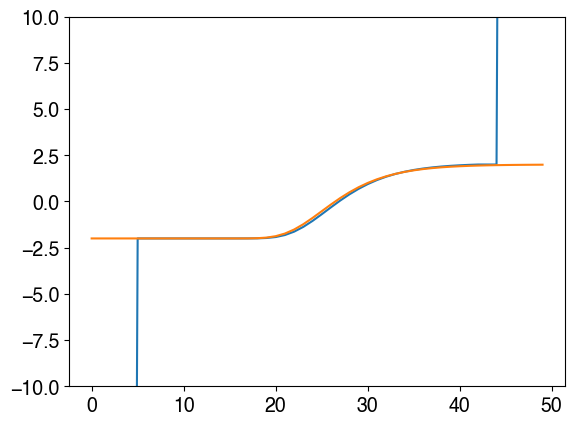

In [13]:
plt.plot(edge_state[:Npopulation])
plt.plot(initial_guess_edge)
plt.axis(ymin=-10,ymax=+10)

In [14]:
def nice_neuron_xlabels(Npopulation):
    labels=['' for i in range(Npopulation)]
    labeled_n = [0,int(Npopulation/2),Npopulation-1]
    for n in labeled_n:
        labels[n] = n
    plt.xticks(ticks=range(Npopulation),labels=labels)
    defaultFigure.makePretty()

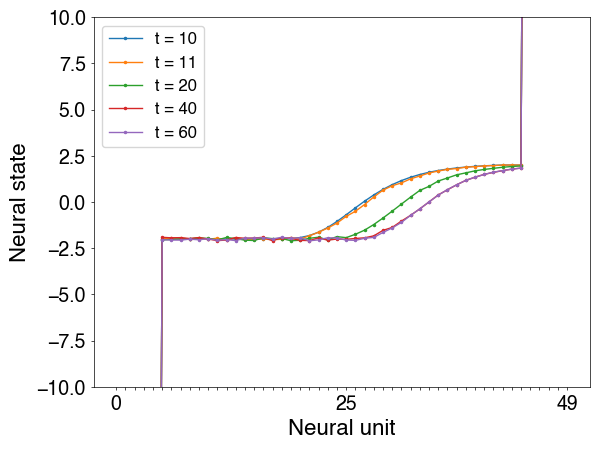

In [40]:
# 2024/1/23 debugging step-function simulation
for t in [10,11,20,40,60]:
    plt.plot(states.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
             '.-',label="t = {}".format(t),lw=1,ms=3)
plt.axis(ymin=-10,ymax=+10)
plt.legend()
plt.xlabel('Neural unit')
plt.ylabel('Neural state')
nice_neuron_xlabels(Npopulation)

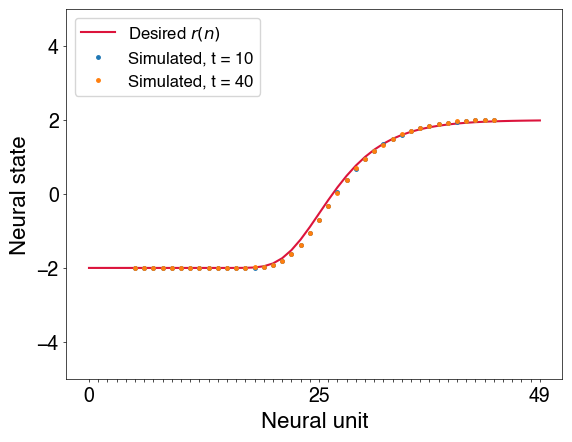

In [36]:
nList = np.arange(0,Npopulation)
t = 20 #1 #20
plt.plot(nList,net.J*(2*desiredEdgeRates(nList,edge_t,delta_z=1/4,n_0=n_0)-1),
         label='Desired $r(n)$',
         color='crimson')

for t in [10,40,]:
    plt.plot(states.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
                 '.',label="Simulated, t = {}".format(t),lw=1,ms=5)
plt.axis(ymin=-5,ymax=+5)
plt.legend()
plt.xlabel('Neural unit')
plt.ylabel('Neural state')
nice_neuron_xlabels(Npopulation)

# plt.plot(nList,desiredBumpRates(nList,t,delta_z=1/2),
#          label='Desired $dr(n)/dn$',
#          color='crimson',ls='--')

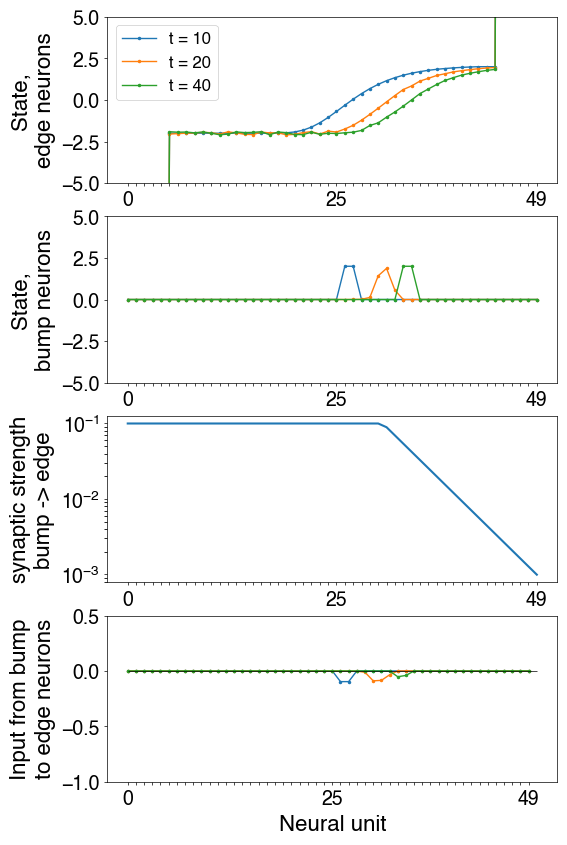

In [41]:
plt.figure(figsize=(6,9))
minInput,maxInput = 0,4
minState,maxState = -5,5 #0,1 #-1,1
#times = [1,2,4,8,16,32] 
times = [10,20,40]

# firing rate plot, edge neurons
plt.subplot(4,1,1)
for t in times:
    plt.plot(states.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
             '.-',label="t = {}".format(t),lw=1,ms=3)
#plt.hlines(0,0,50,color='k',lw=0.5)
#plt.xlabel('Neural unit')
plt.ylabel('State,\nedge neurons')
nice_neuron_xlabels(net.Npopulation)
leg = plt.legend(framealpha=1)
defaultFigure.makePretty(leg=leg)
plt.axis(ymin=minState,ymax=maxState)

# firing rate plot, bump neurons
plt.subplot(4,1,2)
for t in times:
    plt.plot(states.loc[t]['Neuron {}'.format(Npopulation):'Neuron {}'.format(2*Npopulation-1)],
             '.-',label="t = {}".format(t),lw=1,ms=3)
#plt.hlines(0,0,50,color='k',lw=0.5)   
#plt.xlabel('Neural unit')
plt.ylabel('State,\nbump neurons')
nice_neuron_xlabels(net.Npopulation)
#leg = plt.legend(framealpha=1)
defaultFigure.makePretty()
plt.axis(ymin=minState,ymax=maxState)

# interaction strength from bump to edge neurons
plt.subplot(4,1,3)
plt.plot(-np.array(J_bump_edge))
plt.ylabel('synaptic strength\nbump -> edge')
#plt.xlabel('Neural unit')
plt.yscale('log')
nice_neuron_xlabels(net.Npopulation)

# input from bump neurons to edge neurons
plt.subplot(4,1,4)
for t in times:
    activities = np.tanh(states)
    edgeActivities = activities.loc[t]['Neuron {}'.format(Npopulation):'Neuron {}'.format(2*Npopulation-1)]
    bump_to_edge_input = np.dot(edgeActivities,net.bump_edge_Jmat)
    plt.plot(bump_to_edge_input,'.-',label="t = {}".format(t),lw=1,ms=3)
plt.hlines(0,0,50,color='k',lw=0.5)   
plt.xlabel('Neural unit')
plt.ylabel('Input from bump\nto edge neurons')
nice_neuron_xlabels(net.Npopulation)
plt.axis(ymin=-1,ymax=+0.5)


plt.subplots_adjust(bottom=0.1,top=0.95,left=0.2,right=0.95)
#plt.savefig('231117_self_sustained_edge_decaying_velocity.pdf')